In [1]:
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from keras import backend as tf

from keras.utils import plot_model
#keras.utils.vis_utils.pydot = pyd



Using TensorFlow backend.


In [2]:
from scipy.signal import butter, filtfilt

def butter_bandpass(data,lowcut, highcut, fs, order=5,padlen=150):
    nyq = 0.5 * fs

    low = lowcut / nyq
    high = highcut / nyq
    
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data,padlen=padlen)
    return y

In [3]:
sys.path.append(r'E:\PythEnv')
from resnet_model_gpu import resnet_v1, lr_schedule

In [4]:
#%%cache mycache.pkl seismic labels scMin scMax
np.random.seed(13)
nsamp=12000000
thk_min=3    # Minimum thickness measured in samples (dt=1 ms)
thk_mode=5   # modal thickness
thk_max=10   # max thickness
fhcut=80     # high cut for feature vector
flcut=8      # low cut for feature vector
lhcut=300    # high cut for label vector
llcut=3      # low cut for label vector
fs=1000      # sampling freq ---> 1 ms
scMax=5000   # upper limit scale factor
scMin=-5000  # lower limit scale factor  
ntrace=1000  # no sample per trace


## define impedance list
impval=np.int32(np.array(np.linspace(4000,12000,(12000-4000+1))))
imp=np.random.choice(impval,nsamp)


layer_thickness=np.int32(np.random.triangular(thk_min,thk_mode,thk_max,nsamp))

thk_prof=np.cumsum(layer_thickness)
thk_Total=thk_prof[-1]


ref=np.zeros(thk_Total)
##calculate reflectivity series ---> ref=(z2-z1)/(z2+z1)
for ii in range(nsamp-1):
    ref_temp=(imp[ii+1]-imp[ii])/(imp[ii+1]+imp[ii])
    ref[thk_prof[ii]]=ref_temp  

arrlen=len(ref)
ref_rem=arrlen%ntrace

ref_use=arrlen-ref_rem
ref=ref[0:ref_use]
print(ref.shape)

    # Generate the seismic data high resolution pair
seismic=butter_bandpass(ref,flcut, fhcut, fs, order=5)
labels=butter_bandpass(ref,llcut, lhcut, fs, order=5)

(66000000,)


In [12]:
## Normalize the data
seismic=scMin +(seismic-np.min(seismic))*(scMax-scMin)/(np.max(seismic)-np.min(seismic))
labels=scMin +(labels-np.min(labels))*(scMax-scMin)/(np.max(labels)-np.min(labels))

seismic=np.reshape(seismic,(-1,1000))
labels=np.reshape(labels,(-1,1000))

x_train, x_test, y_train, y_test = train_test_split(seismic, labels, test_size=0.25, random_state=42)

print(x_test.shape)


(16500, 1000)


In [13]:
x_test=np.expand_dims(x_test, axis=-1)
x_test=np.expand_dims(x_test, axis=-1)

In [15]:


nrow,ncol,c1,c2=x_test.shape

input_shape=(ncol,c1,c2)
DEPTH=14
batch_size=32
epochs=2000



newmodel = resnet_v1(input_shape=input_shape,depth=DEPTH,num_classes=ncol,
                 num_filters=32, nstack=4, kernel_size=(3,1), pool_size=(2,1))
newmodel.summary()

W1008 23:10:09.201166 15448 deprecation_wrapper.py:119] From C:\Users\aoyem\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1008 23:10:09.225168 15448 deprecation_wrapper.py:119] From C:\Users\aoyem\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1008 23:10:09.230168 15448 deprecation_wrapper.py:119] From C:\Users\aoyem\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000, 1, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1000, 1, 32)  128         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 1000, 1, 32)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1000, 1, 32)  3104        activation_1[0][0]               
__________________________________________________________________________________________________
activation

In [16]:
newmodel.load_weights('resnet_32_s4_weights.h5')

W1008 23:10:20.087789 15448 deprecation_wrapper.py:119] From C:\Users\aoyem\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1008 23:10:20.090789 15448 deprecation_wrapper.py:119] From C:\Users\aoyem\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [17]:
x_pred=newmodel.predict(x_test)

In [18]:
y_test_lb=np.transpose(y_test)
x_pred_sm=np.transpose(np.squeeze(x_pred))

[sz1,sz2]=y_test_lb.shape
samplot=np.random.choice(range(sz2),10)
print(samplot)

[12091  2945  7732 14982  9566  2441  9007 15477  6064  1737]


(10,)


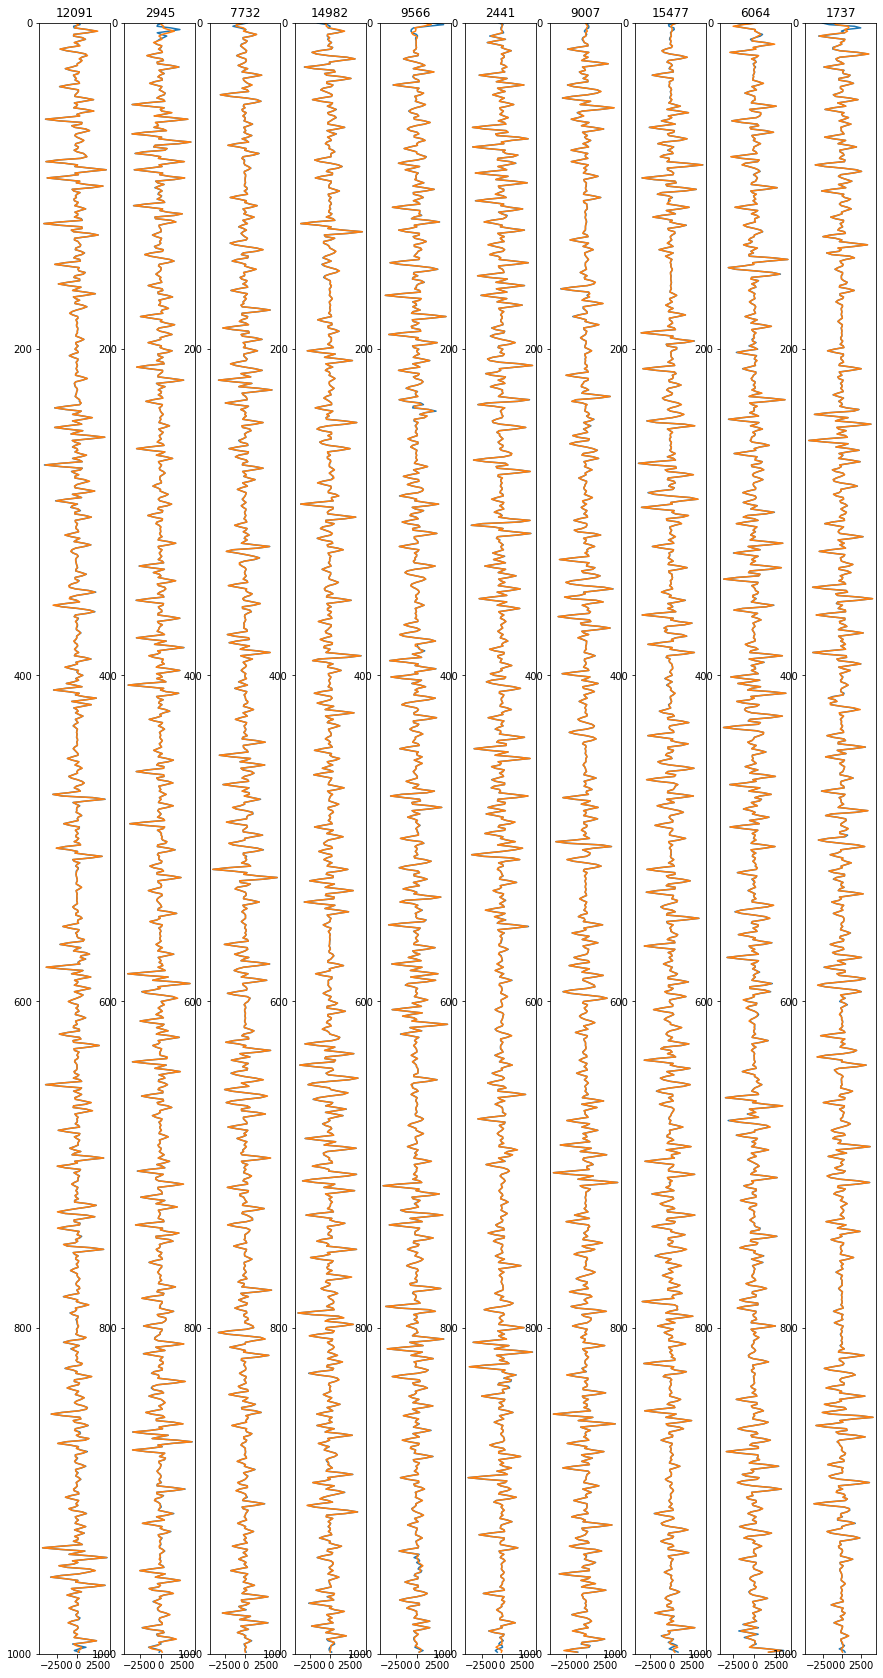

In [19]:
# Plot the data

fig, axs = plt.subplots(nrows=1, ncols=10,figsize=(15, 30)) 
axs=np.ravel(axs)
print(axs.shape)
for aa in range(10):
    xval=samplot[aa]
    axs[aa].plot(y_test_lb[:,xval],np.array(range(1000)))
    axs[aa].plot(x_pred_sm[:,xval],np.array(range(1000)))
    axs[aa].set_title(str(samplot[aa]))
    axs[aa].set_ylim((0,1000)[::-1])
    